### Importing all required modules

In [80]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add, Input, Dropout, Dense, concatenate, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from string import punctuation
import re, os

# Giving us a UI which shall let us see how much data is processed
from tqdm.notebook import tqdm 

# For dumping and reading data into/from files
import pickle

import numpy as np
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

### Loading Captions and Images

In [5]:
# open the file as read only and read linewise
file = open('captions.txt', 'r')
doc = file.readlines()
file.close() # close the file

In [6]:
doc = doc[1:]
len(doc)

40455

In [7]:
captions = {}

for line in tqdm(doc):
    
    # Splitting based on white spaces
    tokens = line.split()
    # First element is related to image id, rest are words of the caption
    img_id, caption = tokens[0].split('.')[0], ' '.join(tokens[1:])
    # Creating a dictionary of img_id-captions(here, 5 captions for each image id)
    if img_id not in captions:
        captions[img_id] = [caption]
    else:
        captions[img_id].append(caption)

print(len(captions))

  0%|          | 0/40455 [00:00<?, ?it/s]

8091


In [8]:
images = os.listdir('images')
len(images)

8091

In [9]:
images[:5]

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg']

### Transfer Learning

In [10]:
# Load the model and restructure it to consider the feature layer and not the classification layer
model = VGG19()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# extract features from each image in images

features = {}
count = 0
for name in tqdm(images):
    # load image from file
    filename = './images/' + name
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to array and reshape it
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the input to make it a sensible input for VGG 19
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    features[name] = feature
    count += 1
    if(count % 20 == 0):
        print(f'{count}> {name}')

  0%|          | 0/8091 [00:00<?, ?it/s]

20> 102351840_323e3de834.jpg
40> 1055623002_8195a43714.jpg
60> 1077546505_a4f6c4daa9.jpg
80> 1093737381_b313cd49ff.jpg
100> 1107471216_4336c9b328.jpg
120> 1130017585_1a219257ac.jpg
140> 1149179852_acad4d7300.jpg
160> 1177994172_10d143cb8d.jpg
180> 121971540_0a986ee176.jpg
200> 124195430_d14028660f.jpg
220> 1259936608_e3f0064f23.jpg
240> 12830823_87d2654e31.jpg
260> 1296770308_3db2022f5a.jpg
280> 1309330801_aeeb23f1ee.jpg
300> 1332208215_fa824f6659.jpg
320> 1348113612_5bfc5f429e.jpg
340> 1356796100_b265479721.jpg
360> 1377668044_36398401dd.jpg
380> 1392272228_cf104086e6.jpg
400> 1403414927_5f80281505.jpg
420> 141755292_7a0b3364cf.jpg
440> 1426014905_da60d72957.jpg
460> 143552829_72b6ba49d4.jpg
480> 1452361926_6d8c535e32.jpg
500> 1463732807_0cdf4f22c7.jpg
520> 1472249944_d887c3aeda.jpg
540> 1482960952_95f2d419cb.jpg
560> 1510078253_96e9ec50e7.jpg
580> 1527513023_3d8152b379.jpg
600> 1562478713_505ab6d924.jpg
620> 1581822598_0ae23074f1.jpg
640> 1625306051_7099519baa.jpg
660> 1676601498_7d5

The process above took nearly 40 minutes, which is definitely not worth repeating every time I begin the project, hence I dump the features dictionary into a pickle file to store the data

In [15]:
# Dump the features dictionary into a pickle file, to avoid having to do the 
pickle.dump(features, open('features.pkl', 'wb'))

### Preprocessing Text Data

**Basic Preprocessing** includes the following:
<ul>
    <li> Removing all occurences of digits in the text</li>
    <li> Stripping off the punctuation marks, except cases like apostrophe in doesn't</li>
    <li> Convert all words into lowercase</li>
    <li> Remove words which contain only single digits like 'a', or may be some other letters, which arose due to removal of digits,etc </li>
    <li> Replace additional white spaces in between words</li>
</ul>

In [11]:
def basic_preprocessing(text):
    text = re.sub(r'\d+', '', text)
    text = " ".join([i.strip(punctuation) for i in text.split()])
    text = " ".join([i.lower() for i in text.split()])
    text = " ".join([i for i in text.split() if len(i) > 1])
    text = text.replace('\s+', ' ').replace('\n','')
    return text

In [12]:
modified_captions = captions.copy()
for img_id, caption_set in modified_captions.items():
    caption_set1 = []
    for caption in caption_set:
        caption_set1.append(basic_preprocessing(caption))
    modified_captions[img_id] = caption_set1

### Train-Test Splitting of Captions

In [13]:
train_size = int(0.9*len(modified_captions))
train_size # size of training data

7281

In [14]:
train_captions = {}
test_captions = {}
count = 1
for img, desc_set in modified_captions.items():
    if(count < train_size + 1):
        train_captions[img] = desc_set
    else:
        test_captions[img] = desc_set
    count += 1

In [15]:
len(train_captions), len(test_captions)

(7281, 810)

### Loading Features

In [16]:
with open('./features.pkl', 'rb') as f: #read binary
    features_loaded = pickle.load(f)

### Making text data training ready

In [17]:
# Adding sos and eos on all captions to indicate beginning and ending of a training caption
for img_id, caption_set in train_captions.items():
    caption_set1 = []
    for caption in caption_set:
        caption_set1.append('startofsequence ' + caption + ' endofsequence')
    train_captions[img_id] = caption_set1

In [18]:
# Adding sos and eos on all captions to indicate beginning and ending of a testing caption
for img_id, caption_set in test_captions.items():
    caption_set1 = []
    for caption in caption_set:
        caption_set1.append('startofsequence ' + caption + ' endofsequence')
    test_captions[img_id] = caption_set1

In [19]:
list(train_captions.items())[:5]

[('1000268201_693b08cb0e',
  ['startofsequence child in pink dress is climbing up set of stairs in an entry way endofsequence',
   'startofsequence girl going into wooden building endofsequence',
   'startofsequence little girl climbing into wooden playhouse endofsequence',
   'startofsequence little girl climbing the stairs to her playhouse endofsequence',
   'startofsequence little girl in pink dress going into wooden cabin endofsequence']),
 ('1001773457_577c3a7d70',
  ['startofsequence black dog and spotted dog are fighting endofsequence',
   'startofsequence black dog and tri-colored dog playing with each other on the road endofsequence',
   'startofsequence black dog and white dog with brown spots are staring at each other in the street endofsequence',
   'startofsequence dogs of different breeds looking at each other on the road endofsequence',
   'startofsequence dogs on pavement moving toward each other endofsequence']),
 ('1002674143_1b742ab4b8',
  ['startofsequence little gi

Captions shall be encoded into numerical format so that the model could play with it. We firstly would need a consistent mapping between vocabulary words to certain unique integer values, that is where **Tokenizers** come to resque.

In [20]:
all_captions = []
# List of all captions
for caption_set in train_captions.values():
    for caption in caption_set:
        all_captions.append(caption)

tokenizer = Tokenizer()
# Assigns unqiue integer to every word
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 # Size of the vocabulary
max_len = max(len(d.split()) for d in all_captions) # Maximum Length of 
vocab_size, max_len

(8017, 33)

It's common for tokenization to result in a smaller vocabulary size due to removal of rare words or any preprocessing steps such as lowercasing, stemming, and removing punctuations.

### Progressive Training to avoid Memory Error

### Building Model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 33, 256)      2052352     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_4[0][0]']                
                                                                                            

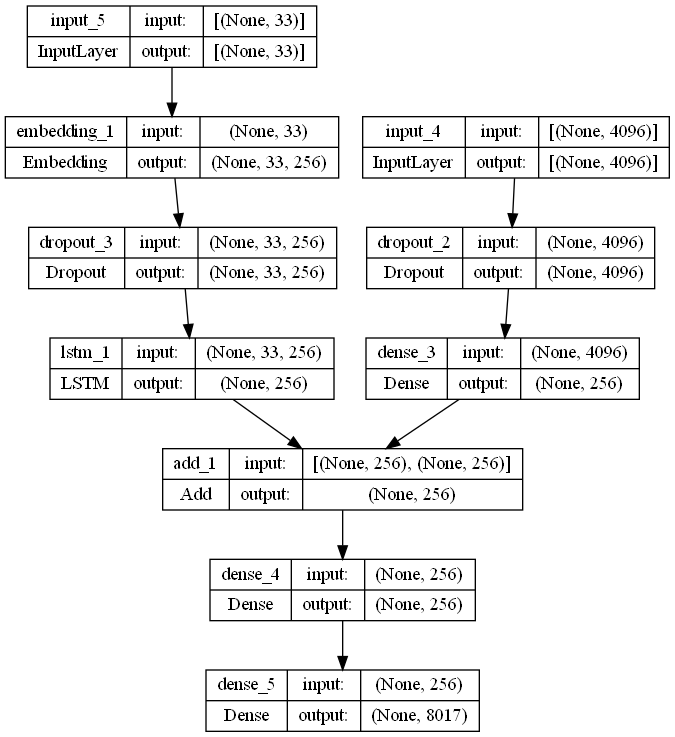

In [44]:
# feature extractor model
inputs1 = Input(shape=(4096,))
dropout1 = Dropout(0.5)(inputs1)
linear1 = Dense(256, activation='relu')(dropout1)

# sequence model
inputs2 = Input(shape=(max_len,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
dropout2 = Dropout(0.5)(embedding)
lstm = LSTM(256)(dropout2)

# decoder model
adder = add([linear1, lstm])
linear3 = Dense(256, activation='relu')(adder)
outputs = Dense(vocab_size, activation='softmax')(linear3)

# Finally bundling all together
ic_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
ic_model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(ic_model.summary())
plot_model(ic_model, show_shapes=True)
# plot_model(ic_model, to_file='model.png', show_shapes=True)

In [45]:
def data_generator(features, image_captions, batch_size, max_doc_len):
    input1 = []
    input2 = []
    output = []
    count = 0
    
    while True:
        for image_id, caption_set in image_captions.items():
            count += 1
            for caption in caption_set:
                encoded_caption = tokenizer.texts_to_sequences([caption])[0] #[0] to convert 2d to 1d
                for i in range(1,len(encoded_caption)):
                    input_sequence = encoded_caption[:i]
                    output_sequence = encoded_caption[i]

                    input1.append(features[image_id+'.jpg'][0]) # again [0] to convert 2d to 1d
                    input2.append(pad_sequences([input_sequence], maxlen = max_doc_len)[0]) # post padding
                    output.append(to_categorical([output_sequence], num_classes = vocab_size)[0])
            if(count % batch_size == 0):
                yield [np.array(input1), np.array(input2)], np.array(output)
                input1, input2, output = [], [], []

In [46]:
batch_size = 32
epochs = 5
steps = int(len(train_captions)/batch_size)

for i in range(epochs):
    print(f'Begin Epoch {i+1}')
    generator = data_generator(features_loaded, train_captions, batch_size, max_len)
    ic_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    print(f'Completed Epoch {i+1}')
    ic_model.save(f'./models/model{i+1}.h5')

Begin Epoch 1
227/227 [==============================] - 405s 2s/step - loss: 5.2667
Completed Epoch 1
Begin Epoch 2
227/227 [==============================] - 411s 2s/step - loss: 4.0959
Completed Epoch 2
Begin Epoch 3
227/227 [==============================] - 475s 2s/step - loss: 3.6785
Completed Epoch 3
Begin Epoch 4
227/227 [==============================] - 424s 2s/step - loss: 3.4105
Completed Epoch 4
Begin Epoch 5
227/227 [==============================] - 424s 2s/step - loss: 3.2121
Completed Epoch 5


In [87]:
for i in range(5,5+epochs):
    print(f'Begin Epoch {i+1}')
    generator = data_generator(features_loaded, train_captions, batch_size, max_len)
    ic_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    print(f'Completed Epoch {i+1}')
    ic_model.save(f'./models/model{i+1}.h5')

Begin Epoch 6
227/227 [==============================] - 394s 2s/step - loss: 3.0611
Completed Epoch 6
Begin Epoch 7
227/227 [==============================] - 418s 2s/step - loss: 2.9406
Completed Epoch 7
Begin Epoch 8
227/227 [==============================] - 409s 2s/step - loss: 2.8446
Completed Epoch 8
Begin Epoch 9
227/227 [==============================] - 419s 2s/step - loss: 2.7605
Completed Epoch 9
Begin Epoch 10
227/227 [==============================] - 439s 2s/step - loss: 2.6887
Completed Epoch 10


In [89]:
for i in range(10,10+epochs):
    print(f'Begin Epoch {i+1}')
    generator = data_generator(features_loaded, train_captions, batch_size, max_len)
    ic_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    print(f'Completed Epoch {i+1}')
    ic_model.save(f'./models/model{i+1}.h5')

Begin Epoch 11
227/227 [==============================] - 423s 2s/step - loss: 2.6251
Completed Epoch 11
Begin Epoch 12
227/227 [==============================] - 442s 2s/step - loss: 2.5681
Completed Epoch 12
Begin Epoch 13
227/227 [==============================] - 440s 2s/step - loss: 2.5180
Completed Epoch 13
Begin Epoch 14
227/227 [==============================] - 461s 2s/step - loss: 2.4748
Completed Epoch 14
Begin Epoch 15
227/227 [==============================] - 465s 2s/step - loss: 2.4359
Completed Epoch 15


### Generating Captions

In [47]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

**We may try implementing Beam Search** with k = 2

In [94]:
def generate_caption(model, tokenizer, photo, max_len):
    # giving the starting word
    in_text = 'startofsequence'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_len)
        # predict next word
        pred_word = model.predict([photo,sequence], verbose=0)
        word_idx = np.argmax(pred_word)
        # map integer to word
        word = word_for_id(word_idx, tokenizer)

        # stop if no word mapped
        if word is None:
            break
        while(word in in_text):
            if(len(word)<=3): break
            pred_word[0][word_idx] = -1
            word_idx = np.argmax(pred_word)
            word = word_for_id(word_idx, tokenizer)
        in_text += ' ' + word

        # stop if eos predicted
        if word == 'endofsequence':
            break
    return in_text

### Manual Evaluation

In [104]:
# Plots image corresponding to index num and shows the generated caption below
def do(num, model):
    name = list(features_loaded.keys())[num]
    filename = './images/' + name
    image = load_img(filename, target_size=(224, 224))
    plt.imshow(image)
    plt.xlabel(generate_caption(model, tokenizer, features_loaded[name], max_len).replace('startofsequence ','').replace('endofsequence',''))
    plt.show()

TRAINING IMAGES


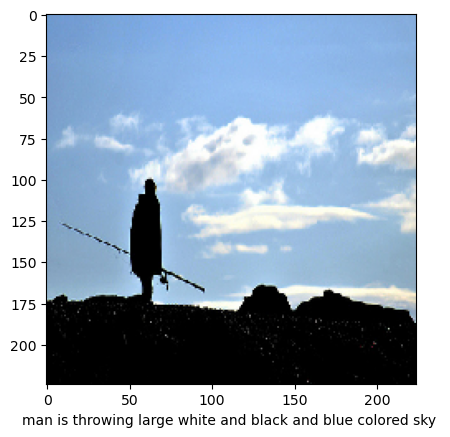

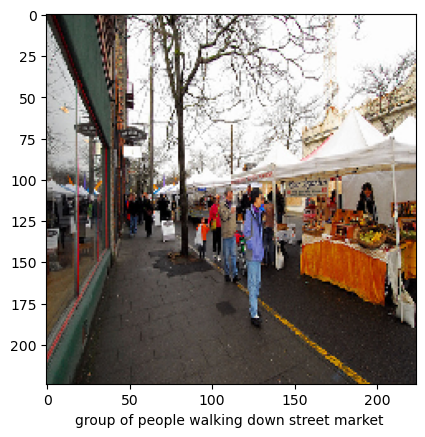

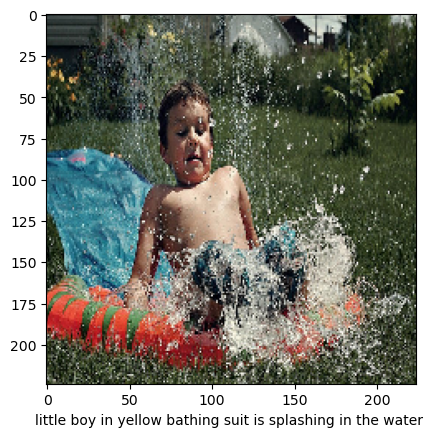

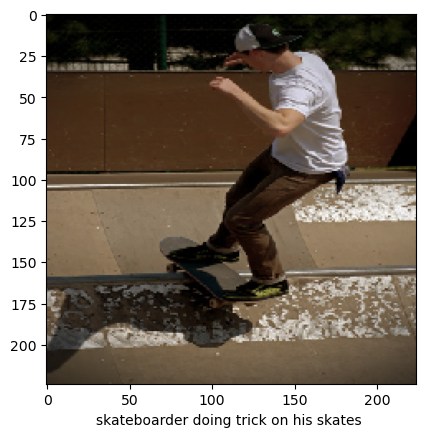

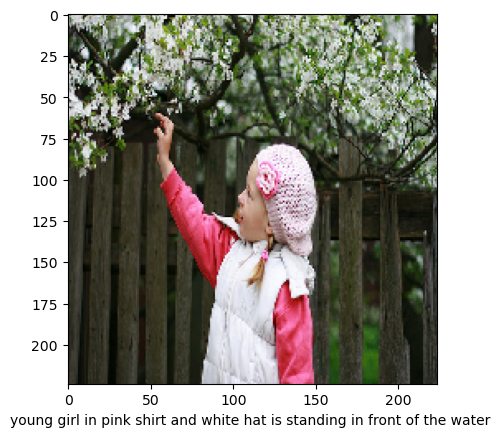

VALIDATION/TESTING IMAGES


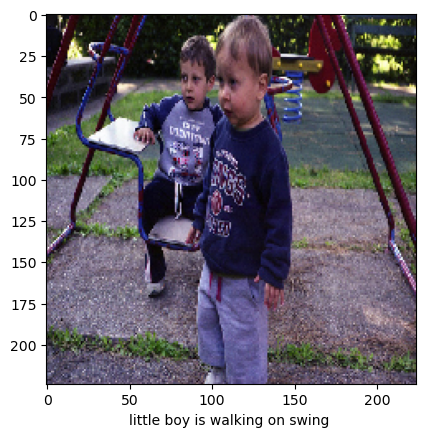

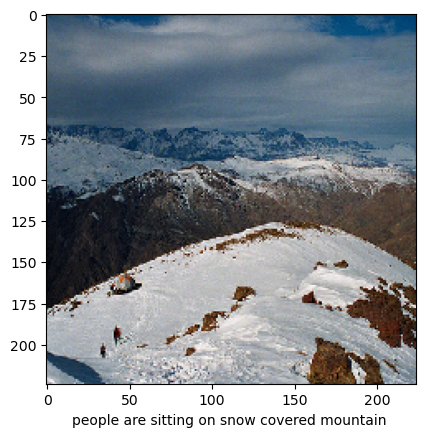

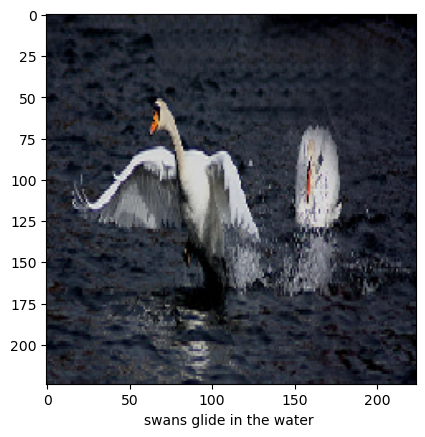

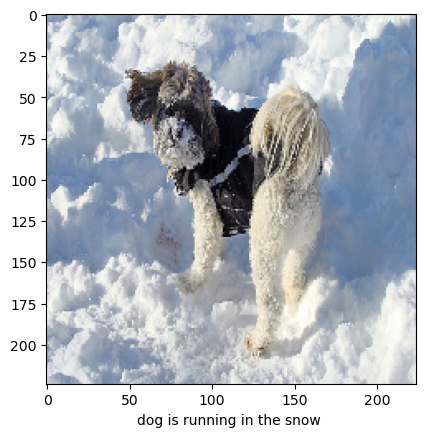

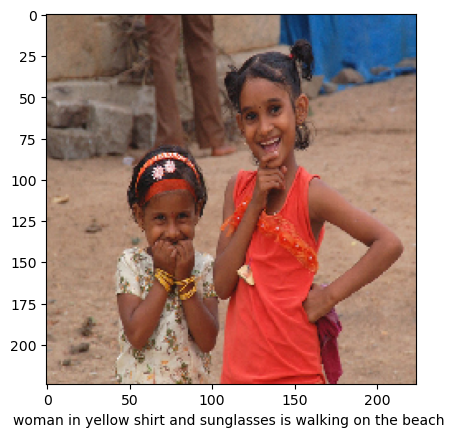

In [105]:
import random
print('TRAINING IMAGES')
nums = random.sample(range(7281), 5)
for num in nums:
    do(num, model_loaded)

print('VALIDATION/TESTING IMAGES')
nums = random.sample(range(7281), 5)
for num in nums:
    do(num, model_loaded)

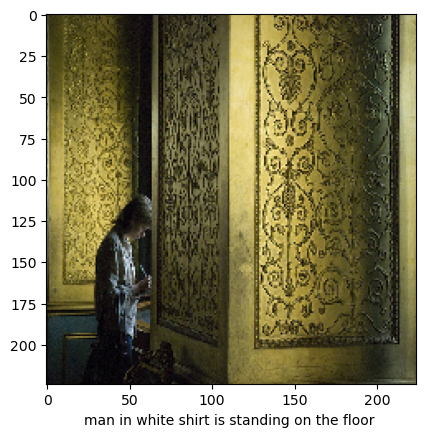

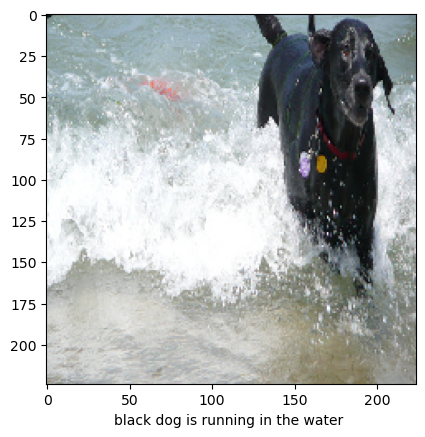

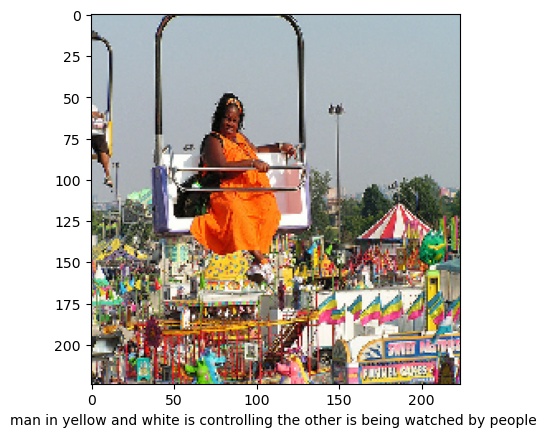

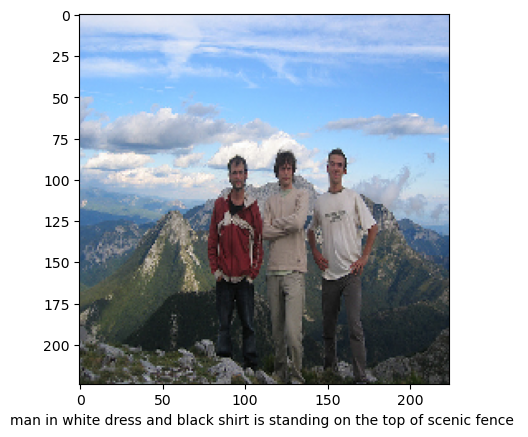

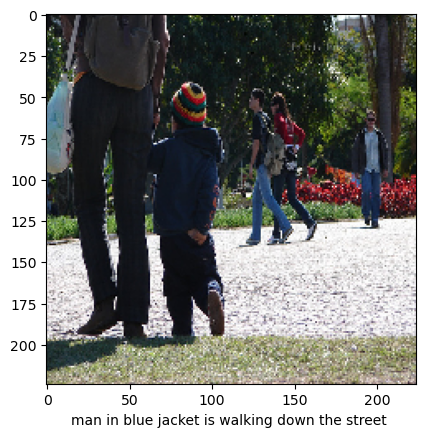

In [106]:
do(-2, ic_model)
do(18, ic_model)
do(-182, ic_model)
do(412, ic_model)
do(7999, ic_model)

### Evaluation

<b> Evaluated in terms of BLEU Score </b>

In [100]:
# evaluate BLEU score
def evaluate_model(model, captions, features, tokenizer, max_len):
    
    actual_captions, generated_captions = [], []
    
    for img_id, caption_set in tqdm(captions.items()):
        #generated_caption = generated_caption.replace('startofsequence ', '').replace(' endofsequence','')
        actual_captions.append([caption.split() for caption in caption_set])
        generated_captions.append(generate_caption(model, tokenizer, features[img_id + '.jpg'], max_len).split())
        
    # BLEU score
    print(f'BLEU-1: {corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))}')
    print(f'BLEU-2: {corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))}')
    print(f'BLEU-3: {corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))}')
    print(f'BLEU-4: {corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))}')

In [101]:
evaluate_model(ic_model, test_captions, features_loaded, tokenizer, max_len)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5455656812625028
BLEU-2: 0.3166670341854713
BLEU-3: 0.19481481751119373
BLEU-4: 0.11620824892743252


In [102]:
model_loaded = load_model('models/model10.h5')

In [103]:
evaluate_model(model_loaded, test_captions, features_loaded, tokenizer, max_len)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5672967433386472
BLEU-2: 0.33848111131407344
BLEU-3: 0.21508410409886328
BLEU-4: 0.13304118750497404
